# Lecture 23-04-2024: Regression Evaluation Metrics


## Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.compose import (
    ColumnTransformer,
    TransformedTargetRegressor,
    make_column_transformer,
)
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LinearRegression, Ridge, RidgeCV
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score, cross_validate, train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.tree import DecisionTreeRegressor

%matplotlib inline

## Announcements

- ICD Exam
- ICD Project
- CDA Project 1

## Learning outcomes

From this lecture, students are expected to be able to:

- Use `Ridge` and `RidgeCV`.
- Explain how `alpha` hyperparameter of `Ridge` relates to the fundamental tradeoff.
- Examine coefficients of transformed features.
- Appropriately select a scoring metric given a regression problem.
- Interpret and communicate the meanings of different scoring metrics on regression problems.
    - MSE, RMSE, $R^2$, MAPE
- Apply log-transform on the target values in a regression problem with `TransformedTargetRegressor`.

## From last Lecture


In [3]:
from sklearn.datasets import fetch_california_housing


california = fetch_california_housing()
X_train, X_test, y_train, y_test = train_test_split(
    california.data, california.target, test_size=0.2
)
pd.DataFrame(X_train, columns=california.feature_names)

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,3.1932,51.0,5.350993,1.238411,608.0,2.013245,36.93,-122.00
1,3.4286,31.0,5.658009,1.060606,752.0,3.255411,32.84,-116.95
2,3.1051,23.0,3.731289,1.031705,4757.0,2.472453,34.20,-118.33
3,1.8939,28.0,5.711640,1.100529,1283.0,3.394180,37.26,-120.49
4,4.8125,48.0,6.764310,1.127946,919.0,3.094276,33.99,-118.34
...,...,...,...,...,...,...,...,...
16507,6.3144,28.0,6.921191,1.036778,1469.0,2.572680,35.28,-120.62
16508,2.0926,11.0,4.134940,0.973494,722.0,1.739759,38.61,-121.34
16509,3.0917,48.0,4.939103,1.006410,819.0,2.625000,33.97,-118.31
16510,0.8026,23.0,5.369231,1.150769,1054.0,3.243077,37.81,-122.29


In [4]:
X_train_df = pd.DataFrame(X_train, columns=california.feature_names)
X_train_df.isna().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

In [5]:
X_train_df.describe()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
count,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000,16512.000000
mean,3.870463,28.683382,5.423245,1.095924,1427.649891,3.103501,35.624089,-119.563443
std,1.894130,12.612377,2.318812,0.453400,1163.218341,11.593708,2.137362,2.002565
min,0.499900,1.000000,0.846154,0.375000,3.000000,0.750000,32.540000,-124.350000
25%,2.566700,18.000000,4.439083,1.005861,788.000000,2.430375,33.930000,-121.790000
50%,3.531300,29.000000,5.232422,1.048780,1160.000000,2.818875,34.250000,-118.490000
75%,4.740250,37.000000,6.058512,1.099536,1722.000000,3.283356,37.720000,-118.000000
max,15.000100,52.000000,132.533333,34.066667,35682.000000,1243.333333,41.950000,-114.310000


## Model building

### `DummyRegressor`

In [6]:
dummy = DummyRegressor()
pd.DataFrame(cross_validate(dummy, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.000815,0.000542,-0.000040,0.0
1,0.000659,0.000307,-0.000018,0.0
2,0.000464,0.000265,-0.000022,0.0
3,0.000458,0.000259,-0.002063,0.0
4,0.000458,0.000256,-0.000165,0.0
5,0.000452,0.000252,-0.001080,0.0
6,0.000459,0.000249,-0.000224,0.0
7,0.000464,0.000237,-0.000027,0.0
8,0.000401,0.000222,-0.000331,0.0
9,0.000403,0.000221,-0.000026,0.0


### Apply `Ridge`

   - It has a hyperparameter `alpha` which controls the fundamental tradeoff.

In [7]:
lr_pipe = make_pipeline(StandardScaler(), Ridge())
pd.DataFrame(cross_validate(lr_pipe, X_train, y_train, cv=10, return_train_score=True))

,fit_time,score_time,test_score,train_score
0,0.037742,0.001188,0.588559,0.611598
1,0.006009,0.000796,0.628565,0.607223
2,0.002488,0.004182,0.612912,0.608946
3,0.002269,0.003565,0.617652,0.608316
4,0.002387,0.007160,0.629292,0.607147
5,0.002845,0.007344,0.594453,0.610809
6,0.003322,0.003266,0.602400,0.610024
7,0.002217,0.000356,0.619691,0.608112
8,0.002149,0.000793,0.540111,0.614582
9,0.002253,0.001666,0.614348,0.608775


### Tuning `alpha` hyperparameter of `Ridge`
- Recall that `Ridge` has a hyperparameter `alpha` that controls the fundamental tradeoff.
- This is like `C` in `LogisticRegression` but, annoyingly, `alpha` is the inverse of `C`.
- That is, large `C` is like small `alpha` and vice versa.
- Smaller `alpha`: lower training error (overfitting)

In [8]:
alphas = 10.0 ** np.arange(-5, 5, 1)
train_scores = []
cv_scores = []
for alpha in alphas:
    lr = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    results = cross_validate(lr, X_train, y_train, return_train_score=True)
    train_scores.append(np.mean(results["train_score"]))
    cv_scores.append(np.mean(results["test_score"]))

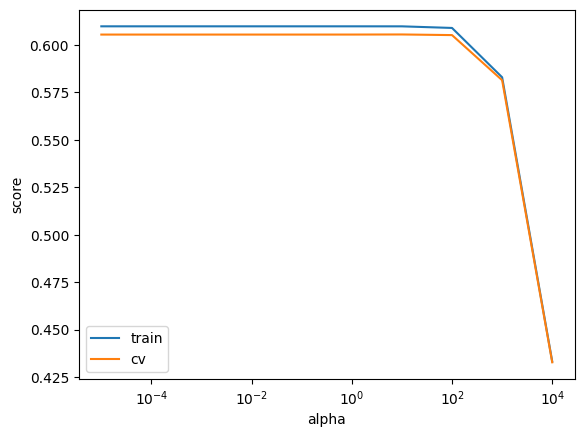

In [9]:
plt.semilogx(alphas, train_scores, label="train")
plt.semilogx(alphas, cv_scores, label="cv")
plt.legend()
plt.xlabel("alpha")
plt.ylabel("score");

In [10]:
best_alpha = alphas[np.argmax(cv_scores)]
best_alpha

10.0

- It seems alpha=10 is the best choice here.

- General intuition: larger `alpha` leads to smaller coefficients.
- Smaller coefficients mean the predictions are less sensitive to changes in the data.
- Hence less chance of overfitting (seeing big dependencies when you shouldn't).

### `RidgeCV`

BTW, because it's so common to want to tune `alpha` with `Ridge`, sklearn provides a class called `RidgeCV`, which automatically tunes `alpha` based on cross-validation.

In [11]:
ridgecv_pipe = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, cv=10))
ridgecv_pipe.fit(X_train, y_train);

In [12]:
best_alpha = ridgecv_pipe.named_steps['ridgecv'].alpha_
best_alpha

10.0

### Let's examine the coefficients

In [13]:
lr_tuned = make_pipeline(StandardScaler(), Ridge(alpha=best_alpha))
lr_tuned.fit(X_train, y_train)
lr_preds = lr_tuned.predict(X_test)
lr_preds[:10]

array([2.06916649, 3.3390054 , 2.25082576, 1.32449208, 1.13831599,
       2.23866556, 0.89485099, 1.32251455, 2.30285326, 1.04322649])

In [14]:
lr_preds.max(), lr_preds.min()

(6.901475874076683, -0.9238172840088699)

array([[<Axes: title={'center': '0'}>]], dtype=object)

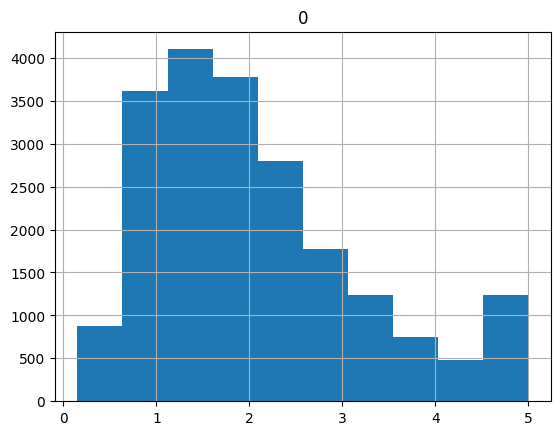

In [20]:
pd.DataFrame(california.target).hist()

Let's get the feature names of the transformed data.

In [21]:
df = pd.DataFrame(
    data={
        "features": X_train_df.columns,
        "coefficients": lr_tuned.named_steps["ridge"].coef_,
    }
)

In [22]:
df.sort_values("coefficients",ascending=False)

,features,coefficients
0,MedInc,0.825610
3,AveBedrms,0.275073
1,HouseAge,0.120808
4,Population,-0.002824
5,AveOccup,-0.040504
2,AveRooms,-0.239915
7,Longitude,-0.857666
6,Latitude,-0.884038


So according to this model:

- As `MedInc` feature gets bigger the housing price will get bigger.


<br><br><br><br>

## Regression score functions

We need a score that reflects how right/wrong each prediction is.

A number of popular scoring functions for regression. We are going to look at some common metrics:

- mean squared error (MSE)
- $R^2$
- root mean squared error (RMSE)
- MAPE

See [sklearn documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#regression-metrics) for more details.

### Mean squared error (MSE)

- A common metric is mean squared error:

In [23]:
preds = lr_tuned.predict(X_train)

In [24]:
np.mean((y_train - preds) ** 2)

0.5145580726243096

Perfect predictions would have MSE=0.

In [23]:
np.mean((y_train - y_train) ** 2)

0.0

This is also implemented in sklearn:

In [25]:
from sklearn.metrics import mean_squared_error

mean_squared_error(y_train, preds)

0.5145580726243096

- Is this score good or bad?

- Unlike classification, with regression **our target has units**.
- The target is in dollars, the mean squared error is in $dollars^2$
- The score also depends on the scale of the targets.

### Root mean squared error or RMSE

- The MSE above is in $dollars^2$.
- A more relatable metric would be the root mean squared error, or RMSE

In [26]:
np.sqrt(mean_squared_error(y_train, lr_tuned.predict(X_train)))

0.7173270332451647

- Error of \$0.72484 makes more sense.
- Can we dig deeper?

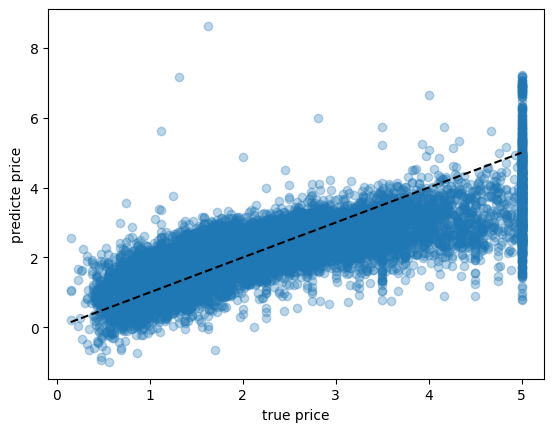

In [28]:
plt.scatter(y_train, lr_tuned.predict(X_train), alpha=0.3)
grid = np.linspace(y_train.min(), y_train.max(), 1000)
plt.plot(grid, grid, "--k")
plt.xlabel("true price")
plt.ylabel("predicted price");

- Here we can see a few cases where our prediction is way off.
- Is there something weird about those houses, perhaps? Outliers?
- Under the line means we're under-prediction, over the line means we're over-predicting.

### $R^2$ (not in detail)

A common score is the $R^2$

- This is the score that `sklearn` uses by default when you call score():
- You can [read about it](https://en.wikipedia.org/wiki/Coefficient_of_determination) if interested.
- Intuition: similar to mean squared error, but flipped (higher is better), and normalized so the max is 1.


$$R^2(y, \hat{y}) = 1 - \frac{\sum_{i=1}^n (y_i - \hat{y_i})^2}{\sum_{i=1}^n (y_i - \bar{y})^2}$$

Key points:
- The maximum is 1 for perfect predictions
- Negative values are very bad: "worse than DummyRegressor" (very bad)


In [29]:
mean_squared_error(y_train, preds)

0.5145580726243096

In [30]:
mean_squared_error(preds, y_train)

0.5145580726243096

In [31]:
r2_score(y_train, preds)

0.6093684738546452

In [32]:
r2_score(preds, y_train)

0.3566772298163543

- When you call `fit` it minimizes MSE / maximizes $R^2$ (or something like that) by default.
- This isn't always what you want!!

### MAPE

- We got an RMSE of ~ 0.72484 before.

Question: Is an error of 0.72484 acceptable?

In [33]:
np.sqrt(mean_squared_error(y_train, lr_tuned.predict(X_train)))

0.7173270332451647

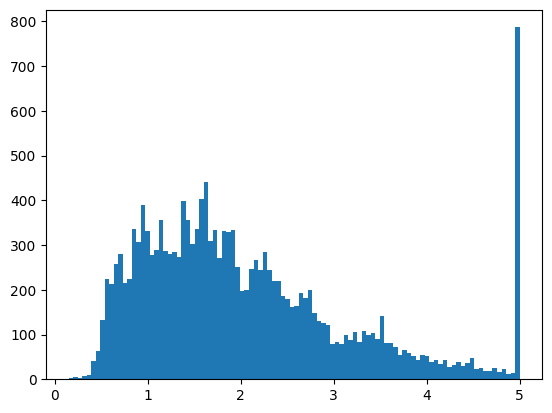

In [34]:
plt.hist(y_train, bins=100);

How about looking at percent error?

In [35]:
pred_train = lr_tuned.predict(X_train)
percent_errors = (pred_train - y_train) / y_train * 100.0
percent_errors

array([-35.37607161,  45.32323369,  -9.62751581, ...,  50.9993222 ,
       -13.37896983, 149.24886944])

These are both positive (predict too high) and negative (predict too low).

We can look at the absolute percent error:

In [36]:
np.abs(percent_errors)

array([ 35.37607161,  45.32323369,   9.62751581, ...,  50.9993222 ,
        13.37896983, 149.24886944])

And, like MSE, we can take the average over examples. This is called mean absolute percent error (MAPE).

In [37]:
def my_mape(true, pred):
    return np.mean(np.abs((pred - true) / true))

In [38]:
my_mape(y_train, pred_train)

0.3156857745489989

Let's use `sklearn` to calculate MAPE.

In [39]:
from sklearn.metrics import mean_absolute_percentage_error

In [40]:
mean_absolute_percentage_error(y_train, pred_train)

0.3156857745489989

- Ok, this is quite interpretable.
- On average, we have around 32% error.

### Transforming the targets

- Does `.fit()` know we care about MAPE?
- No, it doesn't. Why are we minimizing MSE (or something similar) if we care about MAPE??
- When minimizing MSE, the expensive houses will dominate because they have the biggest error.
- Which is better for RMSE?

Model A

- Example 1: Truth: 50k, Prediction: 100k
- Example 2: Truth: 500k, Prediction: 550k
- RMSE: 50k
- MAPE: 45%


Model B

- Example 1: Truth: 50k, Prediction: 60k
- Example 2: Truth: 500k, Prediction: 600k
- RMSE: 71k
- MAPE: 20%

- How can we get `.fit()` to think about MAPE?
- A common practice which tends to work is log transforming the targets.
- That is, transform $y\rightarrow \log(y)$.

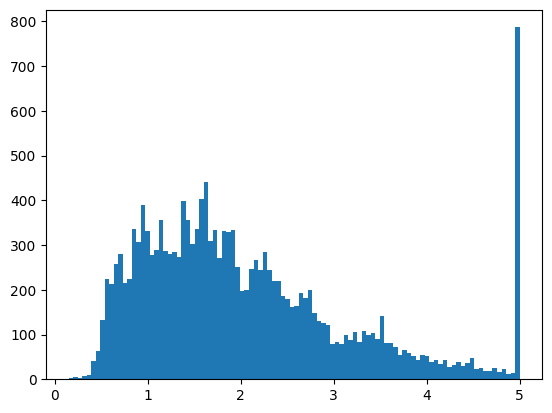

In [41]:
plt.hist(y_train, bins=100);

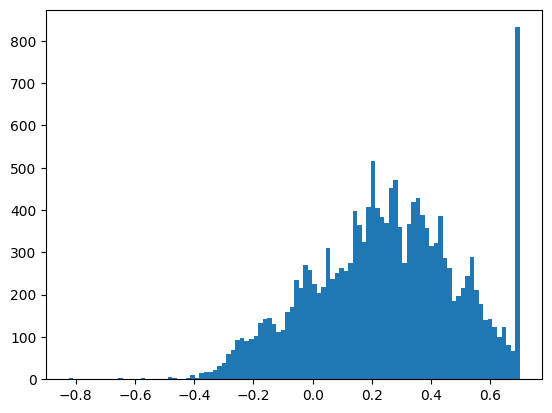

In [42]:
plt.hist(np.log10(y_train), bins=100);

We can incorporate this in our pipeline using `sklearn`.

In [43]:
from sklearn.compose import TransformedTargetRegressor

In [44]:
ttr = TransformedTargetRegressor(
    Ridge(alpha=best_alpha), func=np.log1p, inverse_func=np.expm1
) # transformer for log transforming the target
ttr_pipe = make_pipeline(StandardScaler(), ttr)

In [45]:
ttr_pipe.fit(X_train, y_train); # y_train automatically transformed

In [46]:
ttr_pipe.predict(X_train)  # predictions automatically un-transformed

array([2.40972835, 1.75268753, 1.7661668 , ..., 1.87365336, 1.1426562 ,
       1.05278368])

In [47]:
mean_absolute_percentage_error(y_test, ttr_pipe.predict(X_test))

0.2879101712051621

We didn't reduce MAPE very much!

### Different scoring functions with `cross_validate`

- Let's try using MSE instead of the default $R^2$ score.

In [48]:
pd.DataFrame(
    cross_validate(
        lr_tuned,
        X_train,
        y_train,
        return_train_score=True,
        scoring=["neg_mean_squared_error", "neg_mean_absolute_percentage_error"]
    )
)

,fit_time,score_time,test_neg_mean_squared_error,train_neg_mean_squared_error,test_neg_mean_absolute_percentage_error,train_neg_mean_absolute_percentage_error
0,0.003164,0.002528,-0.511092,-0.515530,-0.315053,-0.315748
1,0.008798,0.001977,-0.514574,-0.514754,-0.310057,-0.317054
2,0.002316,0.001278,-0.499417,-0.518526,-0.319940,-0.314971
3,0.009757,0.000992,-0.513620,-0.514976,-0.320130,-0.315366
4,0.001966,0.000432,-0.559894,-0.506688,-0.315283,-0.314937


In [49]:
def mape(true, pred):
    return mean_absolute_percentage_error(true, pred)


# make a scorer function that we can pass into cross-validation
mape_scorer = make_scorer(mape, greater_is_better=True)

pd.DataFrame(
    cross_validate(
        lr_tuned, X_train, y_train, return_train_score=True, scoring=mape_scorer
    )
)

,fit_time,score_time,test_score,train_score
0,0.003608,0.001743,0.315053,0.315748
1,0.002668,0.003950,0.310057,0.317054
2,0.006163,0.000917,0.319940,0.314971
3,0.003201,0.000335,0.320130,0.315366
4,0.002104,0.000319,0.315283,0.314937


In [50]:
import sklearn
sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'neg_root_mean_squared_log_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 '

In [51]:
scoring = {
    "r2": "r2",
    "neg_mape": "neg_mean_absolute_percentage_error",
    "neg_rmse": "neg_root_mean_squared_error",
    "neg_mse": "neg_mean_squared_error",
}

pd.DataFrame(
    cross_validate(lr_tuned, X_train, y_train, return_train_score=True, scoring=scoring)
).T

,0,1,2,3,4
fit_time,0.003376,0.002647,0.005093,0.003916,0.005503
score_time,0.001543,0.000962,0.008199,0.002231,0.002139
test_r2,0.608604,0.615136,0.612291,0.611596,0.579559
train_r2,0.609476,0.607702,0.608470,0.608660,0.614282
test_neg_mape,-0.315053,-0.310057,-0.319940,-0.320130,-0.315283
train_neg_mape,-0.315748,-0.317054,-0.314971,-0.315366,-0.314937
test_neg_rmse,-0.714907,-0.717338,-0.706694,-0.716673,-0.748260
train_neg_rmse,-0.718004,-0.717464,-0.720087,-0.717618,-0.711820
test_neg_mse,-0.511092,-0.514574,-0.499417,-0.513620,-0.559894
train_neg_mse,-0.515530,-0.514754,-0.518526,-0.514976,-0.506688


In [54]:
mean_absolute_percentage_error(y_test, lr_tuned.predict(X_test))

0.31749121751070586

### Using regression metrics with `scikit-learn`

- In `sklearn` you will notice that it has negative version of the metrics above (e.g., `neg_mean_squared_error`, `neg_root_mean_squared_error`).
- The reason for this is that scores return a value to maximize, the higher the better.
- If you define your own scorer function and if you do not want this interpretation, you can set the `greater_is_better` parameter to False

## Summary

- House prices dataset target is price, which is numeric -> regression rather than classification
- `Ridge` hyperparameter `alpha` is like `LogisticRegression` hyperparameter `C`, but opposite meaning

- Scoring metrics
- $R^2$ is the default .score(), it is unitless, 0 is bad, 1 is best
- MSE (mean squared error) is in units of target squared, hard to interpret; 0 is best
- RMSE (root mean squared error) is in the same units as the target; 0 is best
- MAPE (mean absolute percent error) is unitless; 0 is best, 1 is bad